In [ ]:
# project root 경로 설정

import platform


_ = '\\' if platform.system() == 'Windows' else '/'
root_dir = '/home{_}gusdnd852{_}Github{_}strabismus-recognition{_}'.format(_=_)
if root_dir[len(root_dir) - 1] != _: root_dir += _

In [313]:
import pandas as pd
import numpy as np
import os

In [750]:
# file type에 따라 다른 데이터에 접근

def load_data(classes, max_len, label, short:bool=False):
    file_type = 'fixations' if short else 'all_gaze' 
    raw_data_dir = root_dir + 'data{_}{c}{_}'.format(_=_, c=classes)
    listdir = [_ for _ in os.listdir(raw_data_dir) if file_type in _]
    
    dataset, existing_names = [], ['']
    for filename in listdir:
        file = pd.read_csv(raw_data_dir + filename)
        MEDIA_ID = file['MEDIA_ID'].unique().tolist()

        if len(MEDIA_ID) < 2:
            # 적외선 필터 검사를 진행하지 않은 데이터
            continue  # 데이터 목록에서 제외합니다.
            
        if filename[:3] in existing_names:
            continue # 환자당 데이터 1개씩만 포함
        
        file = file[file['MEDIA_ID'] == MEDIA_ID[-1]]  
        # 적외선 필터 데이터만 로드
        
        data = np.c_[file.LPCX,  file.RPCX, file.LPV, file.RPV]
        columns = ['LPCX', 'RPCX', 'LPV', 'RPV']        
        data = pd.DataFrame(data=data, columns=columns)
        
        # 데이터 전처리 작업 수행
        label = np.array(label)
        data_dict = {'data':data, 'label': label}
        dataset.append(data_dict)
        existing_names.append(filename[:3])
        
    return dataset    

In [751]:
normal = load_data('normal', max_len=1000, label=0)
exotropia = load_data('exotropia', max_len=1000, label=1)
# esotropia = load_data('esotropia', max_len=1000, label=2)
# hypertropia = load_data('hypertropia', max_len=1000, label=3)

In [752]:
import pandas as pd
import numpy as np
import os


def preprocess(data, sampling_rate=10, outlier_threshold=0.025):
    lpcx, rpcx = data['data']['LPCX'], data['data']['RPCX']
    valid = data['data']['LPV'] + data['data']['RPV']
    diff = (rpcx - lpcx).tolist()
    mean = sum(diff) / len(diff)
    
    data_processed = []
    for i, (d, v) in enumerate(zip(diff, valid)):
        if d > mean + outlier_threshold:
            continue
        elif d < mean - outlier_threshold:
            continue
        elif v == 2:
            data_processed.append(d)
    
    data_processed = np.array(data_processed)
    mean = sum(data_processed) / (len(data_processed) + 1)
    data_normalized = np.array([d - mean for d in data_processed])
    
    data_sampled, sampling = [], []
    for i, d in enumerate(data_normalized):
        sampling.append(d)
        
        if len(sampling) > sampling_rate:
            del sampling[0]
        
        if i % sampling_rate == 0 and i > sampling_rate:
               data_sampled.append((sum(sampling) / len(sampling)))
    
    data_sampled = np.array(data_sampled)
    
    return {
        'data' : data_sampled,
        'label' : data['label']
    }

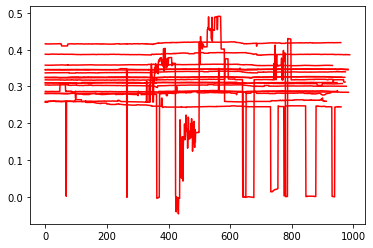

In [774]:
from matplotlib import pyplot as plt

# 전처리 전 정상환자 시각화
outlier_threshold = 0.025
for i in normal:
    plt.plot(i['data']['RPCX'] - i['data']['LPCX'], c='r')
    
plt.show()
plt.close()

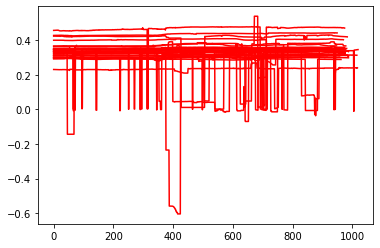

In [775]:
from matplotlib import pyplot as plt

# 전처리 전 정상환자 시각화
outlier_threshold = 0.025
for i in exotropia:
    plt.plot(i['data']['RPCX'] - i['data']['LPCX'], c='r')
    
plt.show()
plt.close()

In [753]:
prep_normal = [preprocess(i) for i in normal if len(preprocess(i)['data']) != 0]
perp_exotropia = [preprocess(i) for i in exotropia if len(preprocess(i)['data']) != 0]

In [754]:
len(prep_normal), len(perp_exotropia)

(17, 30)

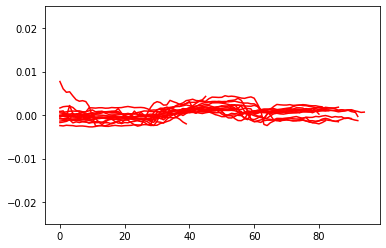

In [778]:
from matplotlib import pyplot as plt

# 전 처리 정상환자 시각화
outlier_threshold = 0.025
for i in prep_normal:
    plt.plot(i['data'], c='r')
    
plt.ylim(-outlier_threshold, outlier_threshold)
plt.show()
plt.close()

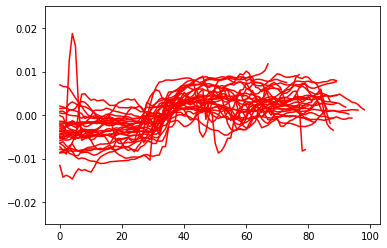

In [779]:
from matplotlib import pyplot as plt

# 전처리 후 정상환자 시각화
outlier_threshold = 0.025
for i in perp_exotropia:
    plt.plot(i['data'], c='r')
    
plt.ylim(-outlier_threshold, outlier_threshold)
plt.show()
plt.close()

In [758]:
dataset = prep_normal + perp_exotropia

In [759]:
def pad_sequence(dataset):
    data = [data['data'] for data in dataset]
    max_len = len(max(data, key=len))
    
    result_arr = []
    for data in dataset:
        label = data['label']
        data = data['data']
        
        zeros = np.zeros(max_len)
        zeros[:len(data)] = data
        result_arr.append({'data':zeros, 'label':label})
    
    return result_arr

In [760]:
padded = pad_sequence(dataset)

In [761]:
def make_dataset(dataset, ratio, unsqueeze=False):
    split_point = int(ratio * len(dataset))
    train_dataset = dataset[:split_point]
    test_dataset = dataset[split_point:]

    train_feature, train_label = [], []
    test_feature, test_label = [], []
    
    for dataset in train_dataset:
        data = np.expand_dims(dataset['data'], axis=0)
        if unsqueeze:
            data = np.expand_dims(data, axis=0)
        label = np.expand_dims(dataset['label'], axis=0)
        train_feature.append(data)
        train_label.append(label)
    
    for dataset in test_dataset:
        data = np.expand_dims(dataset['data'], axis=0)
        if unsqueeze:
            data = np.expand_dims(data, axis=0)
        label = np.expand_dims(dataset['label'], axis=0)
        test_feature.append(data)
        test_label.append(label)
    
    train_feature = np.concatenate(train_feature, axis=0)
    train_label = np.concatenate(train_label, axis=0)
    test_feature = np.concatenate(test_feature, axis=0)
    test_label = np.concatenate(test_label, axis=0)
    
    return train_feature, train_label, test_feature, test_label

In [762]:
import random

random.shuffle(padded)

train_feature, train_label, test_feature, test_label = \
    make_dataset(padded, ratio=0.8, unsqueeze=True)

print(train_label, train_feature.shape)
print(test_label, test_feature.shape)

[0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1] (37, 1, 99)
[0 1 1 0 1 1 1 0 1 1] (10, 1, 99)


In [763]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Bidirectional, LSTM, Dropout, Add
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model

In [764]:
def add_layer(x):
    return BatchNormalization()(Add()([x, Conv1D(1024, kernel_size=1)(x)]))

In [765]:
inputs = Input(shape=(train_feature.shape[1:]))
x = Conv1D(1024, kernel_size=1)(inputs)

for i in range(10):
    x = add_layer(x)

    outputs = Dense(1, activation='sigmoid')(inputs)
model = Model(inputs=inputs, outputs=outputs)

In [766]:
model.compile(optimizer=RMSprop(lr=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_feature, train_label, 
          epochs=5000, 
          batch_size=5,
          validation_data=(test_feature, test_label))

Epoch 1/5000
8/8 [==============================] - 0s 30ms/step - loss: 0.6936 - accuracy: 0.4324 - val_loss: 0.6925 - val_accuracy: 0.7000
Epoch 2/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.6216 - val_loss: 0.6914 - val_accuracy: 0.7000
Epoch 3/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.6912 - accuracy: 0.6216 - val_loss: 0.6902 - val_accuracy: 0.7000
Epoch 4/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.6904 - accuracy: 0.6216 - val_loss: 0.6892 - val_accuracy: 0.7000
Epoch 5/5000
8/8 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.6216 - val_loss: 0.6882 - val_accuracy: 0.7000
Epoch 6/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.6886 - accuracy: 0.6216 - val_loss: 0.6868 - val_accuracy: 0.7000
Epoch 7/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.6876 - accuracy: 0.6216 - val_loss: 0.6858 - val_accuracy: 0.7000
Epoch 8/5000
8/8 [

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f5ff79f96d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1279, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


8/8 [==============================] - 0s 13ms/step - loss: 0.4444 - accuracy: 0.7838 - val_loss: 0.5681 - val_accuracy: 0.8000
Epoch 2204/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4443 - accuracy: 0.7838 - val_loss: 0.5681 - val_accuracy: 0.8000
Epoch 2205/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4443 - accuracy: 0.7838 - val_loss: 0.5680 - val_accuracy: 0.8000
Epoch 2206/5000
8/8 [==============================] - 0s 7ms/step - loss: 0.4443 - accuracy: 0.7838 - val_loss: 0.5680 - val_accuracy: 0.8000
Epoch 2207/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.4443 - accuracy: 0.7838 - val_loss: 0.5681 - val_accuracy: 0.8000
Epoch 2208/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.4442 - accuracy: 0.7838 - val_loss: 0.5682 - val_accuracy: 0.8000
Epoch 2209/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.4442 - accuracy: 0.7838 - val_loss: 0.5682 - val_accuracy: 0.8000
Epoch 2210

KeyboardInterrupt: 